<a href="https://colab.research.google.com/github/NagillaUdayasree/Udayasree_INFO5731_Spring2024/blob/main/Nagilla_Udayasree_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import requests
import json
import time

def calculate_redundancy_with_gpt(df, api_key):
    # Get the count of each term
    term_counts = df['FormalTerm'].value_counts()
    # Identify terms that appear more than once
    duplicate_terms = term_counts[term_counts > 1].index.tolist()
    redundant_terms_count = sum(term_counts[term_counts > 1]) - len(duplicate_terms)  # Subtract to not count the first occurrence

    total_formal_terms = len(df['FormalTerm'])
    checked_terms = 0
    total_terms_to_check = len(duplicate_terms)

    # For each duplicate term, confirm with GPT if it's actually redundant
    for term in duplicate_terms:
        prompt = f"Is the term '{term}' generally known to be a term with multiple meanings or uses in the medical field?"
        is_redundant = ask_gpt(prompt, api_key)
        if not is_redundant:  # If GPT says it's not redundant, we reduce the count
            redundant_terms_count -= (term_counts[term] - 1)

        # Update and print progress
        checked_terms += 1
        progress_percentage = (checked_terms / total_terms_to_check) * 100
        print(f"\rProgress: {progress_percentage:.2f}% complete", end='', flush=True)

    redundancy_percentage = (redundant_terms_count / total_formal_terms) * 100

    return redundancy_percentage, total_formal_terms, redundant_terms_count

def ask_gpt(prompt, api_key):
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
    }
    payload = {
        "model": "gpt-3.5-turbo",
        "messages": [{"role": "user", "content": prompt}]
    }
    max_retries = 10
    retry_delay = 10
    for attempt in range(max_retries):
        response = requests.post(url, headers=headers, data=json.dumps(payload))
        if response.status_code == 200:
            response_json = response.json()
            content = response_json.get('choices', [{}])[0].get('message', {}).get('content', '').lower()
            affirmative_phrases = ['yes', 'true', 'commonly', 'often', 'generally']
            return any(phrase in content for phrase in affirmative_phrases)
        elif response.status_code == 429:
            time.sleep(retry_delay)
            retry_delay *= 1.5
        else:
            print(f"Failed attempt {attempt + 1}: Status code {response.status_code}")
            time.sleep(3)
    raise Exception("Exceeded maximum retries.")

# Loading the dataset from the file
file_path = 'AskAPatient_dataset.xlsx'
df = pd.read_excel(file_path)

#  API key
api_key = 'sk-proj-9hKjQtT6e6orqiwwd10jT3BlbkFJkW2KlXLZ4Ir2B7s6ja5V'

# Calculate redundancy using GPT API
redundancy_percentage, total_terms, redundant_terms = calculate_redundancy_with_gpt(df, api_key)

# Printing the results
print("\nRedundancy Percentage:", redundancy_percentage, "%")
print("Total Formal Terms:", total_terms)
print("Redundant Terms:", redundant_terms)



Progress: 100.00% complete
Redundancy Percentage: 88.77767280341138 %
Total Formal Terms: 156652
Redundant Terms: 139072


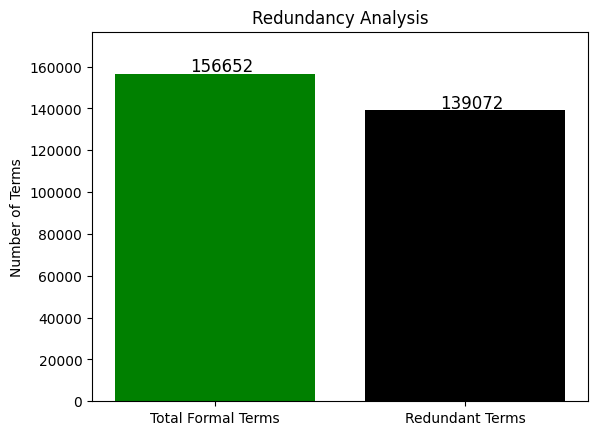

In [13]:
import matplotlib.pyplot as plt

# Data
redundancy_percentage = 88.77767280341138
total_formal_terms = 156652
redundant_terms = 139072

# Plotting
labels = ['Total Formal Terms', 'Redundant Terms']
values = [total_formal_terms, redundant_terms]

plt.bar(labels, values, color=['green', 'black'])
plt.ylabel('Number of Terms')
plt.title('Redundancy Analysis')
plt.text(-0.1, total_formal_terms + 1000, f'{total_formal_terms}', color='black', fontsize=12)
plt.text(0.9, redundant_terms + 1000, f'{redundant_terms}', color='black', fontsize=12)
plt.ylim(0, total_formal_terms + 20000) # Setting y-axis limit to accommodate text

plt.show()


In [4]:
import pandas as pd
import requests
import json
import time

def calculate_uniqueness(df, api_key):
    term_counts = df['FormalTerm'].value_counts()
    unique_terms_count = 0
    processed_terms = 0
    total_terms_to_process = len(term_counts)

    for term, count in term_counts.items():
        # Check if the term is generally known to have multiple meanings
        prompt = f"Is the term '{term}' generally known to be a term with multiple distinct uses in the medical field?"
        if ask_gpt(prompt, api_key):
            # If yes, we consider the first occurrence as unique
            unique_terms_count += 1
        else:
            # If no, we count all occurrences as unique since each is likely context-specific
            unique_terms_count += count
        processed_terms += 1
        print(f"\rProgress: {processed_terms/total_terms_to_process*100:.2f}% complete", end='', flush=True)

    total_formal_terms = len(df['FormalTerm'])
    uniqueness_percentage = (unique_terms_count / total_formal_terms) * 100

    return uniqueness_percentage, total_formal_terms, unique_terms_count

def ask_gpt(prompt, api_key):
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
    }
    payload = {
        "model": "gpt-3.5-turbo",
        "messages": [{"role": "user", "content": prompt}]
    }
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 200:
        response_json = response.json()
        content = response_json.get('choices', [{}])[0].get('message', {}).get('content', '').lower()
        affirmative_phrases = ['yes', 'true', 'commonly', 'often', 'generally']
        return any(phrase in content for phrase in affirmative_phrases)
    else:
        print(f"Error: {response.status_code}, Message: {response.text}")
        return False  # Consider failing the check as not redundant for safety

# Loading the dataset from the file
file_path = 'AskAPatient_dataset.xlsx'
df = pd.read_excel(file_path)

# API key for OpenAI
api_key = 'sk-proj-IgkXC0en5On87FnBgVHqT3BlbkFJDYBeLOtoMsHjvxMJp1I2'

# Calculate uniqueness with potential GPT checks
uniqueness_percentage, total_terms, unique_terms = calculate_uniqueness(df, api_key)

# Print the results
print("\nUniqueness Percentage:", uniqueness_percentage, "%")
print("Total Formal Terms:", total_terms)
print("Unique Terms:", unique_terms)


Progress: 100.00% complete
Uniqueness Percentage: 6.807445803436918 %
Total Formal Terms: 156652
Unique Terms: 10664


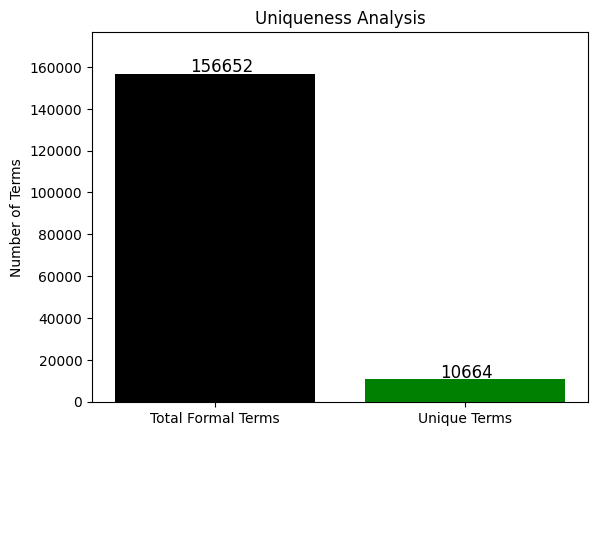

In [15]:
import matplotlib.pyplot as plt

# Data
uniqueness_percentage = 6.807445803436918
total_formal_terms = 156652
unique_terms = 10664

# Plotting
labels = ['Total Formal Terms', 'Unique Terms']
values = [total_formal_terms, unique_terms]

plt.bar(labels, values, color=['black', 'green'])
plt.ylabel('Number of Terms')
plt.title('Uniqueness Analysis')
plt.text(-0.1, total_formal_terms + 1000, f'{total_formal_terms}', color='black', fontsize=12)
plt.text(0.9, unique_terms + 1000, f'{unique_terms}', color='black', fontsize=12)
plt.ylim(0, total_formal_terms + 20000) # Setting y-axis limit to accommodate text

# Adding uniqueness percentage annotation
plt.annotate(f'Uniqueness Percentage: {uniqueness_percentage:.2f}%',
             xy=(0.5, 0), xytext=(0, -40),
             xycoords=('axes fraction', 'figure fraction'),
             textcoords='offset points',
             fontsize=10, color='red',
             ha='center', va='top')

plt.show()


In [14]:
import pandas as pd
import requests

def get_gpt_summary(api_key, completeness_percentage):
    """ This function sends a prompt to GPT-3.5 Turbo and gets a summary based on dataset completeness. """
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
    }
    prompt = f"The dataset has been analyzed for completeness. The completeness percentage is {completeness_percentage}%. Please provide a summary or analysis based on this completeness percentage:"
    payload = {
        "model": "gpt-3.5-turbo",
        "messages": [{"role": "user", "content": prompt}]
    }
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json()['choices'][0]['message']['content']
    else:
        raise Exception(f"API request failed with status {response.status_code}: {response.text}")

def calculate_completeness(df):
    """ This function calculates the completeness of a dataset based on the presence of non-empty 'InformalPhrase'. """
    non_empty_count = df[df['InformalPhrase'].astype(bool)].shape[0]
    total_count = df.shape[0]
    completeness_percentage = (non_empty_count / total_count) * 100
    return completeness_percentage

# Loading the dataset
df = pd.read_excel('AskAPatient_dataset.xlsx')

# API key configuration
api_key = "sk-proj-IgkXC0en5On87FnBgVHqT3BlbkFJDYBeLOtoMsHjvxMJp1I2"

# Calculate the initial completeness percentage
completeness_percentage = calculate_completeness(df)

# Get a GPT-generated summary based on the completeness percentage
summary = get_gpt_summary(api_key, completeness_percentage)

# Print the results
print(f"Completeness Percentage: {completeness_percentage:.2f}%")
print("GPT Summary on Completeness:")
print(summary)


Completeness Percentage: 100.00%
GPT Summary on Completeness:
Based on the completeness percentage of 100.0%, it can be concluded that the dataset contains all of the expected data points and no missing values are present. This high level of completeness indicates that the dataset is reliable and can be used confidently for analysis and decision-making. Researchers can proceed with their analysis knowing that the data is complete and accurate, which will likely lead to more robust and trustworthy results.


In [6]:
!pip install textstat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.4 MB/s eta 0:00:00


In [7]:
import pandas as pd
import requests
import textstat

def calculate_scores(df):
    """ Calculate readability and usefulness scores for the dataset. """
    df['Readability'] = df['InformalPhrase'].apply(textstat.flesch_reading_ease)
    df['Usefulness'] = df.apply(lambda x: 100 if x['InformalPhrase'] != x['FormalTerm'] else 0, axis=1)
    readability_score = df['Readability'].mean()
    usefulness_score = df['Usefulness'].mean()
    return readability_score, usefulness_score

def get_gpt_summary(api_key, readability_score, usefulness_score):
    """ Send a prompt to GPT-3.5 Turbo to get a summary based on readability and usefulness scores. """
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
    }
    prompt = f"The dataset has been analyzed for readability and usefulness. The average readability score is {readability_score:.2f} and the usefulness score is {usefulness_score:.2f}%. Please provide a summary or analysis based on these scores:"
    payload = {
        "model": "gpt-3.5-turbo",
        "messages": [{"role": "user", "content": prompt}]
    }
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json()['choices'][0]['message']['content']
    else:
        raise Exception(f"API request failed with status {response.status_code}: {response.text}")

# Loading the dataset
df = pd.read_excel('AskAPatient_dataset.xlsx')

# API key configuration
api_key = "sk-proj-9hKjQtT6e6orqiwwd10jT3BlbkFJkW2KlXLZ4Ir2B7s6ja5V"

# Calculate readability and usefulness scores
readability_score, usefulness_score = calculate_scores(df)

# Get a GPT-generated summary based on the scores
summary = get_gpt_summary(api_key, readability_score, usefulness_score)

# Print the results
print(f"Readability Score: {readability_score:.2f}")
print(f"Usefulness Score: {usefulness_score:.2f}%")
print("GPT Summary on Scores:")
print(summary)


Readability Score: 39.27
Usefulness Score: 38.81%
GPT Summary on Scores:
Based on the readability score of 39.27, the dataset may be considered to have moderate readability. This means that the language and structure of the dataset may require some effort to understand fully, but it is not overly complex or difficult to comprehend. 

With a usefulness score of 38.81%, it can be inferred that the dataset contains valuable information and insights that are relevant to the topic at hand. However, there may be room for improvement in terms of providing more actionable or practical recommendations based on the analysis.

Overall, the dataset appears to be moderately readable and useful, suggesting that it has the potential to provide valuable insights and information to those who are able to decipher its contents.
